In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from tqdm.notebook import tqdm
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [3]:
device

device(type='cuda')

In [4]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(hue = 0.05, saturation = 0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

In [5]:
cifar_train = torchvision.datasets.CIFAR100(root = './cifar', train = True, download = True, transform = transform)
cifar_test = torchvision.datasets.CIFAR100(root = './cifar', train = False, download = True, transform = base_transform)

train_dataloader = torch.utils.data.DataLoader(cifar_train, batch_size = 40, shuffle = True, num_workers = 4)
test_dataloader = torch.utils.data.DataLoader(cifar_test, batch_size = 40, shuffle = False, num_workers = 4)

100%|██████████| 169M/169M [00:03<00:00, 42.8MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


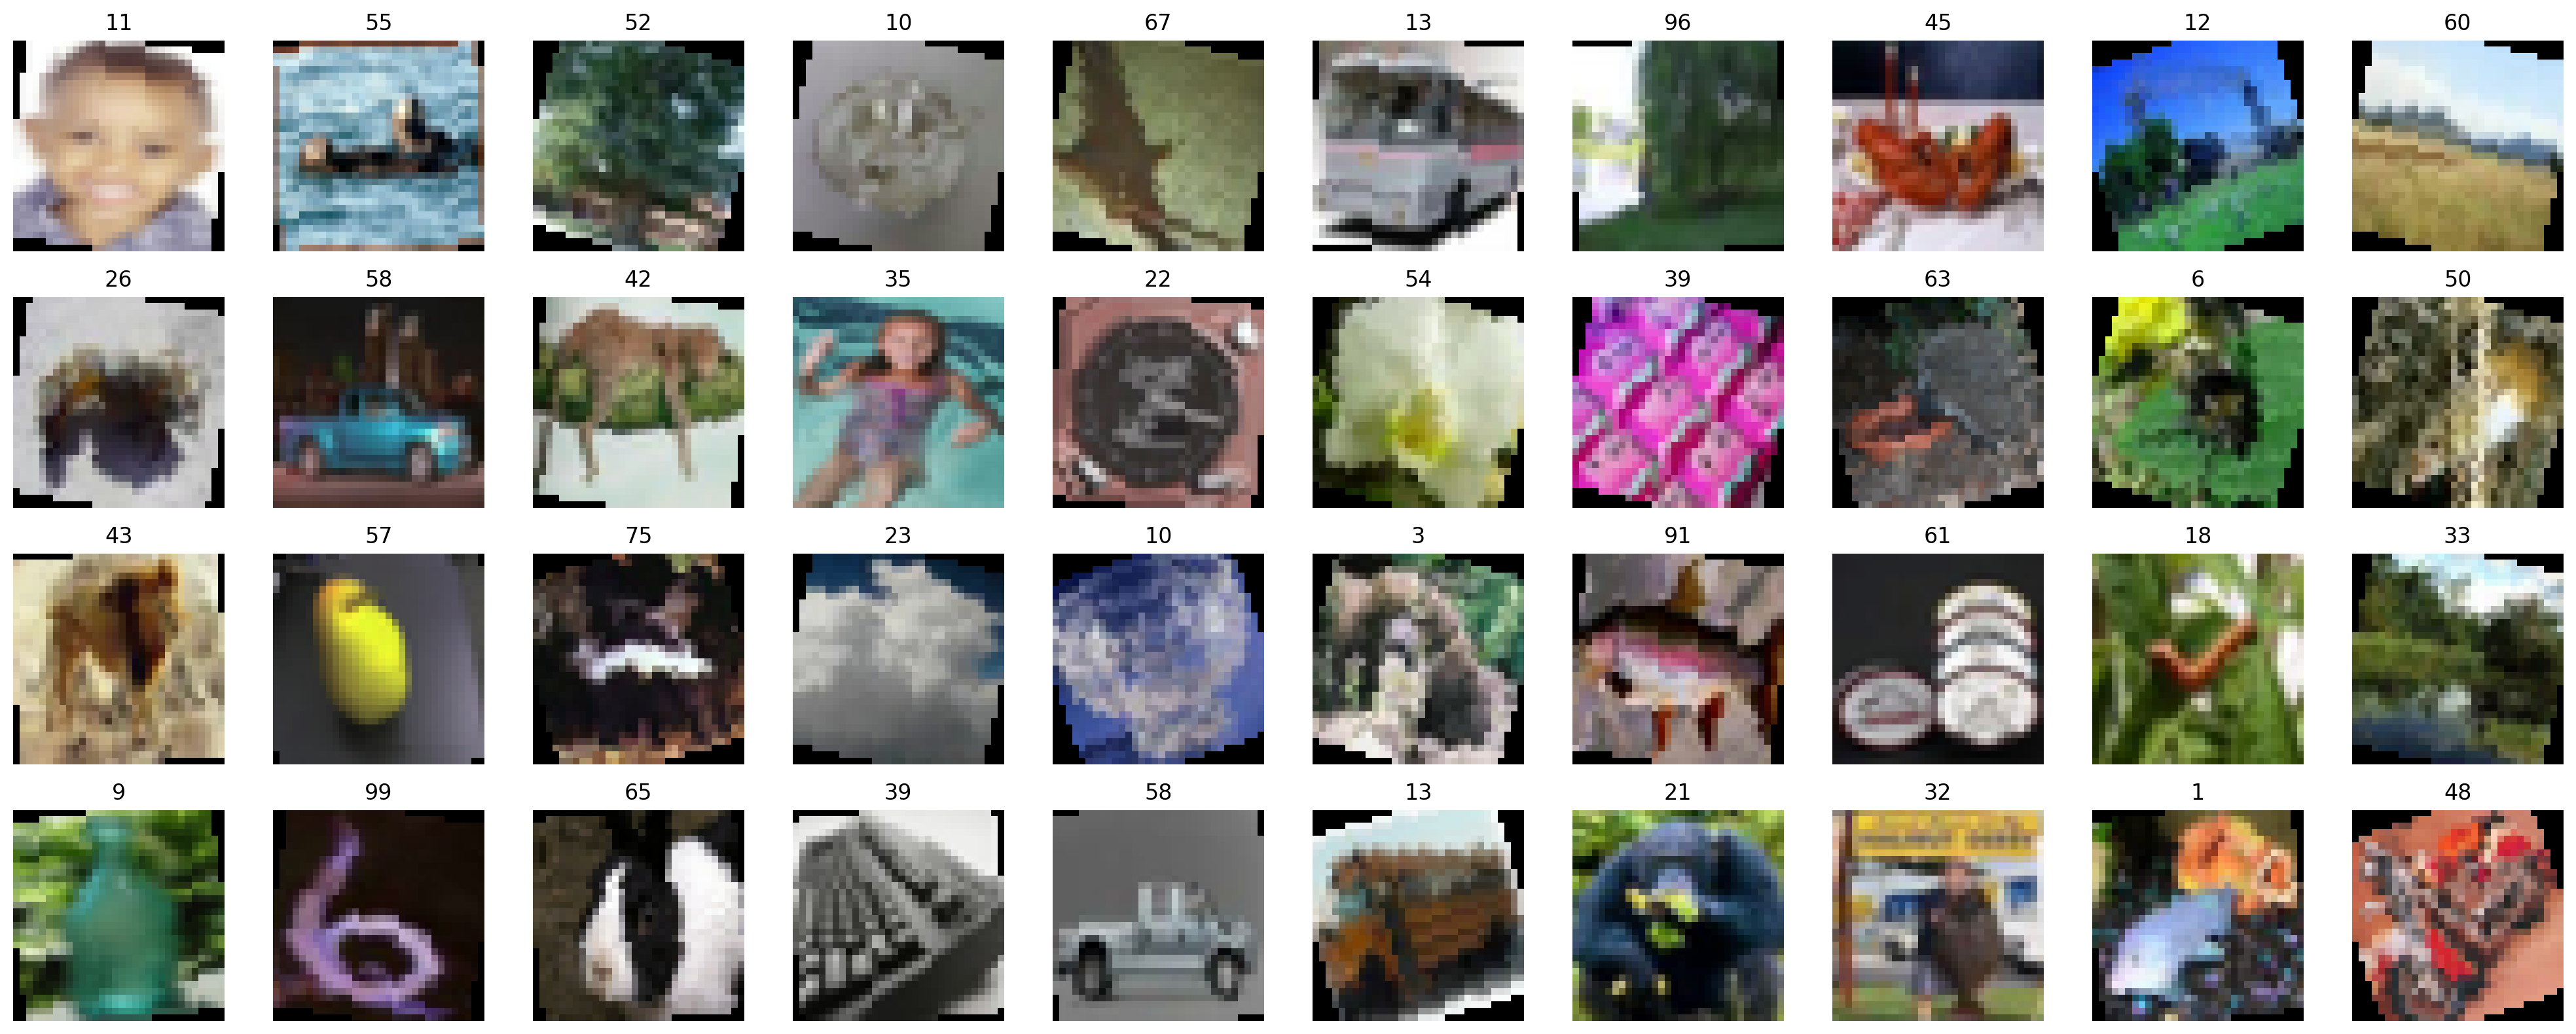

In [6]:
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 10, figsize = (20, 8))

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0)
    img = img * torch.tensor((0.247, 0.243, 0.261)) + torch.tensor((0.4914, 0.4822, 0.4465))
    img = img.clamp(0, 1)
    ax.imshow(img)
    ax.set_title(labels[i].item())
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def train(model, train_dataloader, val_dataloader, optimizer, device, epochs = 10):
    model.to(device)

    val_loss_history = [ ]
    val_acc_history = [ ]

    for epoch in range(epochs):
        model.train()
        for x_train, y_train in tqdm(train_dataloader, desc = f'Epoch {epoch + 1}/{epochs}'):
            y_pred = model(x_train.to(device))
            loss = F.cross_entropy(y_pred, y_train.to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            model.eval()
            val_loss = [ ]
            val_accuracy = [ ]

            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader, desc = 'Validation'):
                    y_pred = model(x_val.to(device))
                    loss = F.cross_entropy(y_pred, y_val.to(device))
                    val_loss.append(loss.item())

                    preds = torch.argmax(y_pred, dim = -1)
                    acc = (preds == y_val.to(device)).float().mean().item()
                    val_accuracy.append(acc)

            mean_loss = np.mean(val_loss)
            mean_acc = np.mean(val_accuracy)

            val_loss_history.append(mean_loss)
            val_acc_history.append(mean_acc)

            print(f'Epoch {epoch + 1}: validation loss = {mean_loss:.4f}, validation accuracy = {mean_acc:.4f}')

    plt.plot(val_loss_history, label = 'Validation Loss', color = 'red')
    plt.plot(val_acc_history, label = 'Validation Accuracy', color = 'green')
    plt.xlabel('Validation step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [8]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Identity()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out = out + self.shortcut(x)
    out = F.relu(out)
    return out

In [9]:
class resnet18(nn.Module):
  def __init__(self, n_classes = 100):
    super().__init__()

    self.residual_block1 = nn.Sequential(
        ResidualBlock(3, 64, 1),
        ResidualBlock(64, 64, 1)
    )

    self.residual_block2 = nn.Sequential(
        ResidualBlock(64, 128, 2),
        ResidualBlock(128, 128, 1)
    )

    self.residual_block3 = nn.Sequential(
        ResidualBlock(128, 256, 2),
        ResidualBlock(256, 256, 1)
    )

    self.residual_block4 = nn.Sequential(
        ResidualBlock(256, 512, 2),
        ResidualBlock(512, 512, 1)
    )

    self.fc_layers = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512 * 1 * 1, n_classes)
    )

  def forward(self, x):
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.residual_block4(x)
        x = self.fc_layers(x)
        return x

In [10]:
ResNet18 = resnet18(n_classes = 100).to(device)

In [11]:
optimizer = optim.SGD(ResNet18.parameters(), lr = 0.001, momentum = 0.9)

Training resnet18 model with 11183460 parameters


Epoch 1/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: validation loss = 3.1741, validation accuracy = 0.2274


Epoch 2/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: validation loss = 2.3814, validation accuracy = 0.3766


Epoch 4/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: validation loss = 2.0422, validation accuracy = 0.4542


Epoch 6/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: validation loss = 1.7570, validation accuracy = 0.5243


Epoch 8/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: validation loss = 1.6609, validation accuracy = 0.5445


Epoch 10/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: validation loss = 1.5359, validation accuracy = 0.5704


Epoch 12/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: validation loss = 1.5139, validation accuracy = 0.5899


Epoch 14/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: validation loss = 1.4240, validation accuracy = 0.6088


Epoch 16/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: validation loss = 1.3915, validation accuracy = 0.6166


Epoch 18/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: validation loss = 1.4020, validation accuracy = 0.6227


Epoch 20/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21: validation loss = 1.4653, validation accuracy = 0.6210


Epoch 22/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23: validation loss = 1.3969, validation accuracy = 0.6372


Epoch 24/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25: validation loss = 1.4261, validation accuracy = 0.6374


Epoch 26/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27: validation loss = 1.4323, validation accuracy = 0.6376


Epoch 28/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29: validation loss = 1.4367, validation accuracy = 0.6427


Epoch 30/30:   0%|          | 0/1250 [00:00<?, ?it/s]

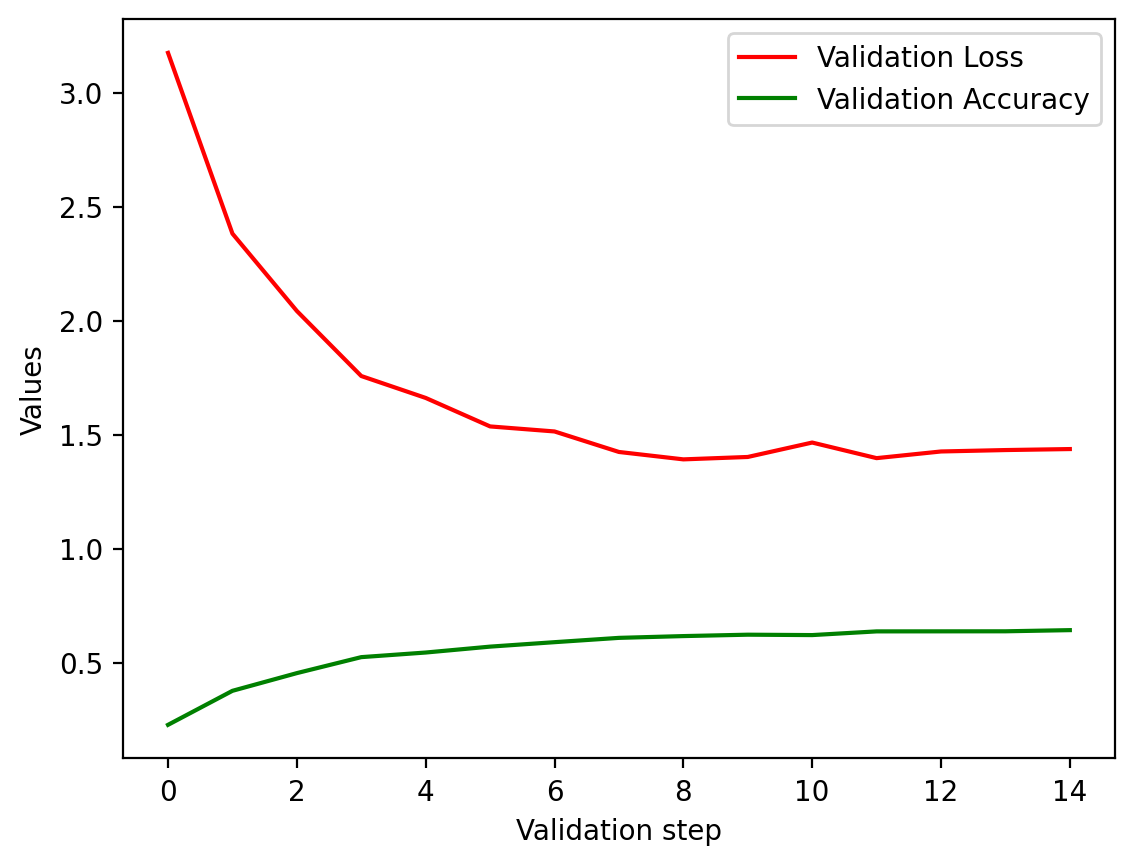

In [12]:
print(f'Training resnet18 model with {sum([x[1].numel() for x in ResNet18.named_parameters()])} parameters')
train(ResNet18, train_dataloader, test_dataloader, optimizer, device, epochs = 30)

In [13]:
class resnet34(nn.Module):
  def __init__(self, n_classes = 100):
    super().__init__()

    self.residual_block1 = nn.Sequential(
        ResidualBlock(3, 64, 1),
        ResidualBlock(64, 64, 1),
        ResidualBlock(64, 64, 1)
    )

    self.residual_block2 = nn.Sequential(
        ResidualBlock(64, 128, 2),
        ResidualBlock(128, 128, 1),
        ResidualBlock(128, 128, 1),
        ResidualBlock(128, 128, 1)
    )

    self.residual_block3 = nn.Sequential(
        ResidualBlock(128, 256, 2),
        ResidualBlock(256, 256, 1),
        ResidualBlock(256, 256, 1),
        ResidualBlock(256, 256, 1),
        ResidualBlock(256, 256, 1),
        ResidualBlock(256, 256, 1)
    )

    self.residual_block4 = nn.Sequential(
        ResidualBlock(256, 512, 2),
        ResidualBlock(512, 512, 1),
        ResidualBlock(512, 512, 1)
    )

    self.fc_layers = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512 * 1 * 1, n_classes)
    )

  def forward(self, x):
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.residual_block4(x)
        x = self.fc_layers(x)
        return x

In [14]:
ResNet34 = resnet34(n_classes = 100).to(device)

In [15]:
optimizer = optim.SGD(ResNet34.parameters(), lr = 0.001, momentum = 0.9)

Training resnet34 model with 21291620 parameters


Epoch 1/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: validation loss = 3.1812, validation accuracy = 0.2198


Epoch 2/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: validation loss = 2.3316, validation accuracy = 0.3957


Epoch 4/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: validation loss = 1.9360, validation accuracy = 0.4835


Epoch 6/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: validation loss = 1.7393, validation accuracy = 0.5213


Epoch 8/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: validation loss = 1.5848, validation accuracy = 0.5627


Epoch 10/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: validation loss = 1.5231, validation accuracy = 0.5843


Epoch 12/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: validation loss = 1.4917, validation accuracy = 0.5925


Epoch 14/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: validation loss = 1.4934, validation accuracy = 0.6045


Epoch 16/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: validation loss = 1.5294, validation accuracy = 0.6089


Epoch 18/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: validation loss = 1.4892, validation accuracy = 0.6200


Epoch 20/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21: validation loss = 1.4969, validation accuracy = 0.6210


Epoch 22/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23: validation loss = 1.5017, validation accuracy = 0.6237


Epoch 24/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25: validation loss = 1.5477, validation accuracy = 0.6293


Epoch 26/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27: validation loss = 1.5666, validation accuracy = 0.6319


Epoch 28/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29: validation loss = 1.5859, validation accuracy = 0.6294


Epoch 30/30:   0%|          | 0/1250 [00:00<?, ?it/s]

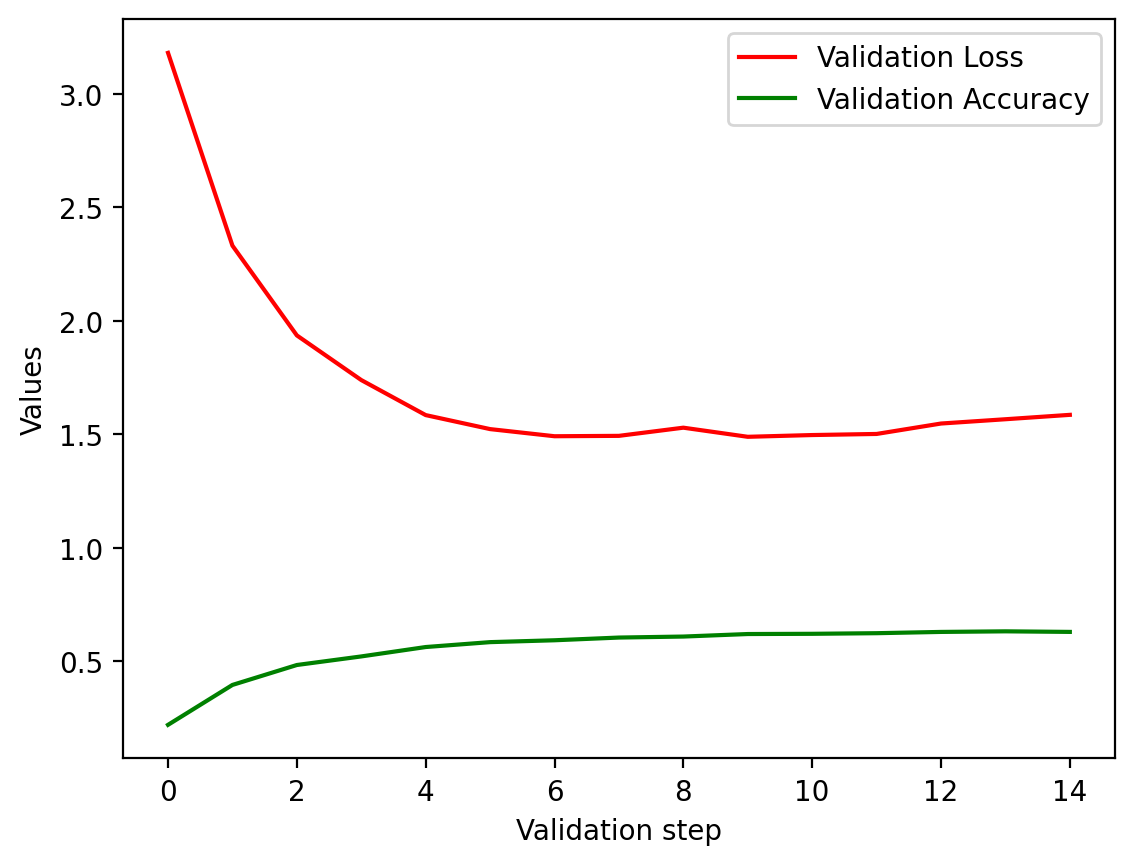

In [16]:
print(f'Training resnet34 model with {sum([x[1].numel() for x in ResNet34.named_parameters()])} parameters')
train(ResNet34, train_dataloader, test_dataloader, optimizer, device, epochs = 30)